# 0. Overview

The image dataset contains five different types of flower.<br>
This notebook will adopt CNN and ResNet model to do flower image classification.<br>
And this notebook is inspired by and modified from deeplearning.ai happyhouse project.<br>

#### 1. Load Flower Image Data
#### 2. Preprocessing
a. Split the dataset to training and validation set<br>
b. Onehot encoding target variable<br>
c. Image augmentation using Keras<br>
#### 3. Build CNN
a. Simple baseline ConvNet model without scaling and image augmentation<br>
b. Simple baseline ConvNet with scaling and image augmentation<br>
c. Residual Network

# 1. Load Flower Image Data

- create a configure object containing root directory and all necessary subdirectories
- images of flowers are stored in five different subfolders under data directory
- five subfolders' name are:
    1. daisy
    2. dandelion
    3. rose
    4. sunflower
    5. tulip

In [2]:
class Config:
    
    root_dir = 'D:\\Job\\Codes\\'
    data_dir = root_dir + 'Data\\flowers\\'
    # five subfolders which contain corresponding image of flower are under data_dir

config = Config

In [3]:
import os
import numpy as np
from keras.preprocessing import image

- Instead of being stored in the same folder, each type of flower image data is stored in corresponding subfolder
- So we loop over 5 subfolders to load image data of 5 types of flower,and extract the corresponding label

In [4]:
def read_image_as_array(img_resolution):
    
    """
    Args:
        img_resolution (int): The target size of image.
    
    Returns:
        X (numpy array): A numpy array contains image data in the shape of (example number, img_resolution, img_resolution, 3).
        y (numpy array): A numpy 1d array contains image's label index.
        label_dict (dict): A dictonary maps flower label index to flower label name.
    """
    
    # retain data directory from config
    # list all flower subfolders in data directory
    data_dir = Config.data_dir
    flower_subfolders = os.listdir(data_dir)
    
    # initialize numpy array to store image data and label
    X = np.empty((0, img_resolution, img_resolution, 3))
    y = np.empty((0), dtype = 'int')
    # create a dictionary to map label index to corresponding label name
    label_dict = {}
    
    # loop over 5 flower subfolders to load image data
    for ind, f in enumerate(flower_subfolders):
        
        flower_subfolders_dir = os.path.join(data_dir, f)
        # file length in flower_subfolder is example number of each flower_subfolder
        m = len(os.listdir(flower_subfolders_dir))
        # initialize numpy array to store data in each flower_subfolder
        X_sub = np.empty((m, img_resolution, img_resolution, 3))
        
        # loop over all images in each flower_subfolder
        for i, img in enumerate(os.listdir(flower_subfolders_dir)):
            
            # load image data with target size img_resolution x img_resolution and convert it to array of shape (img_resolution, img_resolution, 3)
            x = image.img_to_array(image.load_img(os.path.join(flower_subfolders_dir, img), target_size = (img_resolution, img_resolution)))
            # insert array
            X_sub[i, :, :, :] = x
        
        # store mapping for label index and corresponding label name
        label_dict[int(ind)] = f
        # populate label index and concatenate 5 subfolders' label index
        y = np.concatenate((y, np.array([int(ind)] * m)))
        # concatenate 5 subfolders' image data array
        X = np.concatenate((X, X_sub))
        
        print(f, ' Finished')
    
    return X, y, label_dict

In [5]:
# target size 64 to allow image data fit in local memory
img_resolution = 64
X, y, label_dict = read_image_as_array(img_resolution)

daisy  Finished
dandelion  Finished
rose  Finished
sunflower  Finished
tulip  Finished


- each image is in shape of (img_resolution, img_resolution, 3)

In [6]:
print(X[0].shape)

(64, 64, 3)


- there are 4323 images in total

In [7]:
print('Image Number: {}'.format(X.shape[0]))

Image Number: 4323


- number of 5 flower types' image

In [8]:
for label_index in np.unique(y, return_counts = True)[0]:
    
    print('{0:<9} {1:^12} {2:.0%}'.format(label_dict[label_index],
                                          np.unique(y, return_counts = True)[1][label_index],
                                          round(np.unique(y, return_counts = True)[1][label_index] / y.shape[0], 2)))

daisy         769      18%
dandelion     1052     24%
rose          784      18%
sunflower     734      17%
tulip         984      23%


- image example

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_image(X, y, index, label_dict):
    
    """
    Args:
        X (numpy array): A numpy array contains image data in the shape of (example number, img_resolution, img_resolution, 3).
        y (numpy array): A numpy 1d array contains image's label index.
        index (int): A integer index of X to be plotted.
        label_dict (dict): A dictonary maps flower label index to flower label name.
    
    Returns:
        None
    """
    
    image = X[index, :, :, :].astype('int32')
    plt.imshow(image)
    print('The flower is: ', label_dict[y[index]])

The flower is:  dandelion


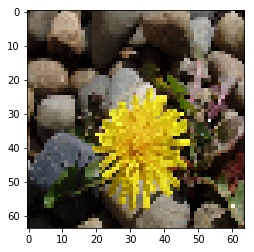

In [10]:
plot_image(X, y, 1100, label_dict)

# 2. Preprocessing

### a. Split the dataset to training and validation set

In [11]:
from sklearn.model_selection import train_test_split

- split to 70% training and 30% validation with stratified sampling

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size = 0.3, 
                                                  stratify = y,
                                                  random_state = 1)

- example number

In [13]:
print('Training Set Number: {}'.format(X_train.shape[0]))
print('Validation Set Number: {}'.format(X_val.shape[0]))

Training Set Number: 3026
Validation Set Number: 1297


- make sure target variable distrubtion for training set and validation set is the same
- there is no label imbalance problem

In [14]:
print('Training set target variable label weights: \n')
for label_index in np.unique(y_train, return_counts = True)[0]:
    
    print('{0:<14} {1:.0%}'.format(label_dict[label_index], 
                                   round(np.unique(y_train, return_counts = True)[1][label_index] / y_train.shape[0], 2)))
    
print('\nValidation set target variable label weights: \n')
for label_index in np.unique(y_val, return_counts = True)[0]:
    
    print('{0:<14} {1:.0%}'.format(label_dict[label_index], 
                                   round(np.unique(y_val, return_counts = True)[1][label_index] / y_val.shape[0], 2)))

Training set target variable label weights: 

daisy          18%
dandelion      24%
rose           18%
sunflower      17%
tulip          23%

Validation set target variable label weights: 

daisy          18%
dandelion      24%
rose           18%
sunflower      17%
tulip          23%


- b. Onehot encoding target variable

In [15]:
from keras.utils import to_categorical

In [16]:
y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)

- target variable is onehot encoded to 5 dimension

In [17]:
print(y_train.shape)
print(y_train_oh.shape)

(3026,)
(3026, 5)


In [18]:
print(y_val.shape)
print(y_val_oh.shape)

(1297,)
(1297, 5)


### Image augmentation using Keras

- image augmentation could be used to create more training examples by shifting, rotating, or chaning color of images, and then help the model to reduce variance
- use Keras ImageDataGenerator to create a generator which could be passed into Keras model and fit the augmented training images to the model directly
- for validation data, we only scale the image data without any augmentation

In [19]:
datagen = image.ImageDataGenerator(width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   rescale = 1. / 255)

datagen_val = image.ImageDataGenerator(rescale = 1. / 255)

# 3. Build CNN

In [20]:
from keras.layers import Conv2D, BatchNormalization, Activation, Dense, Input, MaxPool2D, Flatten, Add
from keras.models import Model
from keras import optimizers, initializers
from keras import regularizers

### a. Simple baseline ConvNet without scaling and image augmentation

- first start from a simple network without residual block and without any image augmentation
- in general, the deeper the Covnet, the size of featured picture will be smaller whereas the channel number will be more.

In [21]:
def CovNet(input_shape, n_classes):
    
    """
    Args:
        input_shape (tuple): The input shape of one single image.
        n_classes (int): The dimension of target variable.
    Return:
        model (keras model): A keras CNN model.
    
    """
    
    # use keras input layer, shape should be (resolution, resolution, 3)
    Input_layer = Input(shape = input_shape)
    
    # first Conv layer with same paddind and batchnorm
    X = Conv2D(kernel_size = 4, padding = 'same', strides = 1, filters = 4, kernel_initializer = initializers.glorot_uniform(seed = 1))(Input_layer)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # second Conv layer: decrease picture size from 64 to 25, and have 16 channels
    X = Conv2D(kernel_size = 16, padding = 'valid', strides = 2, filters = 16, kernel_initializer = initializers.glorot_uniform(seed = 1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # add pooling layer to extract some possible features
    # reduce size from 25 to 16
    X = MaxPool2D(pool_size = 10, strides = 1)(X)
    
    # fully connected layer and output layer with softmax activation
    X = Flatten()(X)    
    X = Dense(n_classes)(X)
    Output_layer = Activation('softmax')(X)
    
    # input and output for model
    model = Model(inputs = Input_layer, outputs = Output_layer)
    print(model.summary())
    # call the adam optimizer
    opt = optimizers.Adam(lr = adam_opt_param.learning_rate, 
                          beta_1 = adam_opt_param.beta_1, 
                          beta_2 = adam_opt_param.beta_2, 
                          epsilon = adam_opt_param.epsilon)
    # model to compile all
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['categorical_accuracy'])
    
    return model
    

- hyper-parameters for Adam optimizer

In [22]:
class adam_opt_param:
    
    learning_rate = 0.001
    beta_1 = 0.9
    beta_2 = 0.999 
    epsilon = 10**-8

- model summary

In [23]:
input_shape = X_train[0].shape
n_classes = y_train_oh.shape[1]

model_baseline = CovNet(input_shape, n_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 4)         196       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 4)         16        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 16)        16400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 25, 25, 16)        0         
__________

- fit the model with data without augmentation

In [24]:
epochs = 30
batch_size = 32

history_baseline = model_baseline.fit(x = X_train, y = y_train_oh,
                                      epochs = epochs,
                                      batch_size = batch_size,
                                      validation_data = (X_val, y_val_oh),
                                      verbose = 2)

Train on 3026 samples, validate on 1297 samples
Epoch 1/30
 - 5s - loss: 2.0584 - categorical_accuracy: 0.3361 - val_loss: 1.3567 - val_categorical_accuracy: 0.4426
Epoch 2/30
 - 3s - loss: 1.2953 - categorical_accuracy: 0.4699 - val_loss: 1.4070 - val_categorical_accuracy: 0.4364
Epoch 3/30
 - 3s - loss: 1.1795 - categorical_accuracy: 0.5416 - val_loss: 1.1707 - val_categorical_accuracy: 0.5359
Epoch 4/30
 - 3s - loss: 1.0867 - categorical_accuracy: 0.5747 - val_loss: 1.1586 - val_categorical_accuracy: 0.5698
Epoch 5/30
 - 4s - loss: 1.1065 - categorical_accuracy: 0.5876 - val_loss: 1.1981 - val_categorical_accuracy: 0.5482
Epoch 6/30
 - 3s - loss: 0.9906 - categorical_accuracy: 0.6295 - val_loss: 1.1878 - val_categorical_accuracy: 0.5829
Epoch 7/30
 - 3s - loss: 0.9286 - categorical_accuracy: 0.6517 - val_loss: 1.4898 - val_categorical_accuracy: 0.4765
Epoch 8/30
 - 3s - loss: 0.8965 - categorical_accuracy: 0.6662 - val_loss: 0.9868 - val_categorical_accuracy: 0.6307
Epoch 9/30
 - 3s

- plot and observe training and validation error to reduce bias or variance

In [25]:
def plot_metric_loss(history, metrics):
    
    """
    Args:
        history (keras history): The output history of a keras model
        metrics (str): The metrics used in the fitted keras model
    
    Returns:
        None
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 6))
    
    ax1.plot(history.history[metrics])
    ax1.plot(history.history['val_' + metrics])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Val'], loc = 'upper left')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Val'], loc = 'upper left')
    
    plt.show()

- We could observe that the model is overfitting after 10 epochs since the validation error keeps rising while training error keeps reducing to almost 0.
- The solution for overfitting are
    1. Searching for better network structure or hyper-parameters
    2. Collecting more data
    3. Adding more regularization

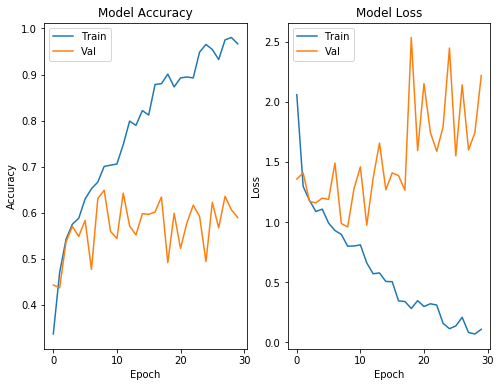

In [26]:
plot_metric_loss(history_baseline, 'categorical_accuracy')

### b. Simple baseline ConvNet with scaling and image augmentation

- Since the baseline has high variance problem, we use image augmentation to generate more variant images
- The way to implement this is to pass keras imagedatagenerator directly to model

In [27]:
model_aug = CovNet(input_shape, n_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 4)         196       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 4)         16        
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 16)        16400     
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 25, 16)        64        
_________________________________________________________________
activation_5 (Activation)    (None, 25, 25, 16)        0         
__________

- fit the model with image augmentation using keras imagedatagenerator

In [28]:
epochs = 30
batch_size = 32

history_aug = model_aug.fit_generator(generator = datagen.flow(x = X_train, y = y_train_oh, batch_size = batch_size),
                                      steps_per_epoch = X_train.shape[0] // batch_size,
                                      epochs = epochs,
                                      validation_data = datagen_val.flow(x = X_val, y = y_val_oh, batch_size = batch_size),
                                      validation_steps = X_val.shape[0] // batch_size,
                                      verbose = 2)

Epoch 1/30
 - 4s - loss: 1.6505 - categorical_accuracy: 0.3700 - val_loss: 1.4258 - val_categorical_accuracy: 0.4742
Epoch 2/30
 - 3s - loss: 1.3285 - categorical_accuracy: 0.4463 - val_loss: 1.3711 - val_categorical_accuracy: 0.4609
Epoch 3/30
 - 3s - loss: 1.2146 - categorical_accuracy: 0.5181 - val_loss: 1.3176 - val_categorical_accuracy: 0.4783
Epoch 4/30
 - 3s - loss: 1.2276 - categorical_accuracy: 0.5368 - val_loss: 1.3734 - val_categorical_accuracy: 0.5012
Epoch 5/30
 - 3s - loss: 1.1213 - categorical_accuracy: 0.5646 - val_loss: 1.0073 - val_categorical_accuracy: 0.6126
Epoch 6/30
 - 3s - loss: 1.1195 - categorical_accuracy: 0.5602 - val_loss: 1.0522 - val_categorical_accuracy: 0.5960
Epoch 7/30
 - 3s - loss: 1.0420 - categorical_accuracy: 0.5989 - val_loss: 1.0551 - val_categorical_accuracy: 0.6055
Epoch 8/30
 - 3s - loss: 0.9866 - categorical_accuracy: 0.6236 - val_loss: 0.9317 - val_categorical_accuracy: 0.6522
Epoch 9/30
 - 3s - loss: 0.9936 - categorical_accuracy: 0.6174 -

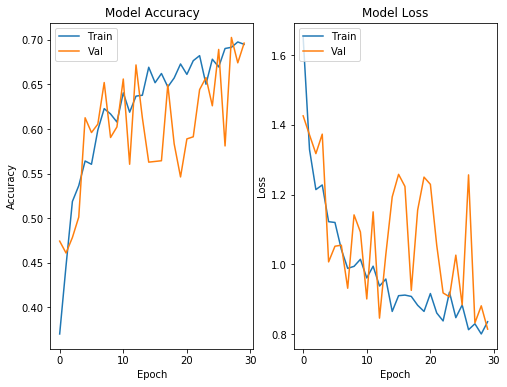

In [29]:
plot_metric_loss(history_aug, 'categorical_accuracy')

- you could now see that after image augmentation, the high variance problem is well handled
- but image augmentation also cause high bias problem as our training accuracy is only 69%
- The solution for underfitting are
    1. Building a deeper network
    2. Training longer
    3. Searching for better network structure or hyper-parameters

### c. Residual Network

- here we will try to build a deeper network to solve high bias problem
- but deeper network usually causes gradient exploding / vanishing problem
- as a result, we will adopt residual blocks in our model to build ResNet to solve gradient exploding / vanishing problem

- identity block: The retained shortcut tensor is in the same size of final component tensor of the main path

In [30]:
def identity_block(X, f, filters):
    
    """
    Args:
        X (keras model tensor): A keras tensor contains previous network.
        f (int): A int to decide the kernel size of the same padding conv2d layer.
        filters (list): A list contain filter number of all three conv2d layers.
    
    Returns:
        X (keras model tensor): A keras tensor with identity block.
    """
    
    # retrieve filter number
    F1, F2, F3 = filters
    
    # retain X
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(kernel_size = 1, padding = 'valid', strides = 1, filters = F1, kernel_initializer = initializers.uniform(seed = 1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(kernel_size = f, padding = 'same', strides = 1, filters = F2, kernel_initializer = initializers.uniform(seed = 1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(kernel_size = 1, padding = 'valid', strides = 1, filters = F3, kernel_initializer = initializers.uniform(seed = 1))(X)
    X = BatchNormalization()(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

- convolutional block: The retained shortcut tensor needs one more Conv2D to be transformed to the same size of final component tensor of the main path

In [31]:
def convolutional_block(X, f, filters, s = 2):
    
    """
    Args:
        X (keras model tensor): A keras tensor contains previous network.
        f (int): A int to decide the kernel size of the same padding conv2d layer.
        filters (list): A list contain filter number of all three conv2d layers.
        s (int): A int to decide the stride step of the first component of main path.
    
    Returns:
        X (keras model tensor): A keras tensor with convolutional block.
    """
    
    # retrieve filter number
    F1, F2, F3 = filters
    
    # retain X
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(kernel_size = 1, padding = 'valid', strides = s, filters = F1, kernel_initializer = initializers.glorot_uniform(seed = 1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

     # Second component of main path 
    X = Conv2D(kernel_size = f, padding = 'same', strides = 1, filters = F2, kernel_initializer = initializers.glorot_uniform(seed = 1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
     # Third component of main path
    X = Conv2D(kernel_size = 1, padding = 'valid', strides = 1, filters = F3, kernel_initializer = initializers.glorot_uniform(seed = 1))(X)
    X = BatchNormalization()(X)
    
    # Shortcut path
    X_shortcut = Conv2D(kernel_size = 1, padding = 'valid', strides = s, filters = F3, kernel_initializer = initializers.glorot_uniform(seed = 1))(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

- main structure of the Residual Network

In [32]:
def ResNet(input_shape, n_classes):
    
    # use keras input layer, shape should be (resolution, resolution, 3)
    Input_layer = Input(shape = input_shape)
    
    # first Conv layer with same paddind and batchnorm
    X = Conv2D(kernel_size = 3, padding = 'same', strides = 1, filters = 8, kernel_initializer = initializers.glorot_uniform(seed = 1))(Input_layer)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # add pooling layer to extract some possible features
    # reduce size from 64 to 59
    X = MaxPool2D(pool_size = 6, strides = 1)(X)
    
    # apply identity block and convolutional block built above
    # reduce size from 59 to 30
    X = convolutional_block(X, 3, [8, 8, 16], s = 2)
    X = identity_block(X, 3, [8, 8, 16])
    X = identity_block(X, 3, [8, 8, 16])
    # reduce size from 30 to 15
    X = convolutional_block(X, 3, [32, 64, 128], s = 2)
    
    # fully connected layer and output layer with softmax activation
    X = Flatten()(X)
    X = Dense(n_classes)(X)
    Output_layer = Activation('softmax')(X)
    
    # input and output for model
    model = Model(inputs = Input_layer, outputs = Output_layer)
    print(model.summary())
    # call the adam optimizer
    opt = optimizers.Adam(lr = adam_opt_param.learning_rate, 
                          beta_1 = adam_opt_param.beta_1, 
                          beta_2 = adam_opt_param.beta_2, 
                          epsilon = adam_opt_param.epsilon)
    # model to compile all
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['categorical_accuracy'])

    return model

In [33]:
class adam_opt_param:
    
    learning_rate = 0.001
    beta_1 = 0.9
    beta_2 = 0.999 
    epsilon = 10**-8

- fit the model with image augmentation using keras imagedatagenerator
- use more variant generator to prevent overfitting and reduce variance

In [35]:
datagen2 = image.ImageDataGenerator(width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30,
                                   horizontal_flip = True,
                                   shear_range = 0.3,
                                   zoom_range = 0.3,
                                   rescale = 1. / 255)

In [36]:
model_resnet2 = ResNet(input_shape, n_classes)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 8)    224         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 64, 64, 8)    32          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 64, 64, 8)    0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
max_poolin

- train longer to reduce bias

In [37]:
epochs = 150
batch_size = 32

history_resnet2 = model_resnet2.fit_generator(generator = datagen2.flow(x = X_train, y = y_train_oh, batch_size = batch_size),
                                             steps_per_epoch = X_train.shape[0] // batch_size,
                                             epochs = epochs,
                                             validation_data = datagen_val.flow(x = X_val, y = y_val_oh, batch_size = batch_size),
                                             validation_steps = X_val.shape[0] // batch_size,
                                             verbose = 2)

Epoch 1/150
 - 11s - loss: 2.9265 - categorical_accuracy: 0.3807 - val_loss: 2.9362 - val_categorical_accuracy: 0.4242
Epoch 2/150
 - 7s - loss: 1.3952 - categorical_accuracy: 0.5102 - val_loss: 3.0581 - val_categorical_accuracy: 0.3881
Epoch 3/150
 - 7s - loss: 1.2323 - categorical_accuracy: 0.5342 - val_loss: 1.5582 - val_categorical_accuracy: 0.4838
Epoch 4/150
 - 7s - loss: 1.1553 - categorical_accuracy: 0.5417 - val_loss: 1.6059 - val_categorical_accuracy: 0.4957
Epoch 5/150
 - 7s - loss: 1.0840 - categorical_accuracy: 0.5756 - val_loss: 1.3855 - val_categorical_accuracy: 0.5399
Epoch 6/150
 - 7s - loss: 1.0360 - categorical_accuracy: 0.5901 - val_loss: 1.2001 - val_categorical_accuracy: 0.5889
Epoch 7/150
 - 7s - loss: 1.0285 - categorical_accuracy: 0.5996 - val_loss: 1.2163 - val_categorical_accuracy: 0.5739
Epoch 8/150
 - 7s - loss: 1.0059 - categorical_accuracy: 0.6076 - val_loss: 1.1702 - val_categorical_accuracy: 0.5850
Epoch 9/150
 - 7s - loss: 0.9893 - categorical_accuracy

Epoch 70/150
 - 7s - loss: 0.6401 - categorical_accuracy: 0.7600 - val_loss: 1.0038 - val_categorical_accuracy: 0.6957
Epoch 71/150
 - 7s - loss: 0.6524 - categorical_accuracy: 0.7582 - val_loss: 0.8466 - val_categorical_accuracy: 0.7273
Epoch 72/150
 - 7s - loss: 0.6722 - categorical_accuracy: 0.7520 - val_loss: 0.8867 - val_categorical_accuracy: 0.7083
Epoch 73/150
 - 7s - loss: 0.6131 - categorical_accuracy: 0.7713 - val_loss: 1.0225 - val_categorical_accuracy: 0.7036
Epoch 74/150
 - 7s - loss: 0.6575 - categorical_accuracy: 0.7544 - val_loss: 0.9616 - val_categorical_accuracy: 0.7107
Epoch 75/150
 - 7s - loss: 0.6691 - categorical_accuracy: 0.7501 - val_loss: 1.0323 - val_categorical_accuracy: 0.6980
Epoch 76/150
 - 7s - loss: 0.6419 - categorical_accuracy: 0.7646 - val_loss: 1.0996 - val_categorical_accuracy: 0.6617
Epoch 77/150
 - 7s - loss: 0.6600 - categorical_accuracy: 0.7589 - val_loss: 0.8998 - val_categorical_accuracy: 0.7186
Epoch 78/150
 - 7s - loss: 0.6167 - categorical_

Epoch 139/150
 - 7s - loss: 0.5508 - categorical_accuracy: 0.7931 - val_loss: 0.7926 - val_categorical_accuracy: 0.7510
Epoch 140/150
 - 7s - loss: 0.4924 - categorical_accuracy: 0.8143 - val_loss: 0.9724 - val_categorical_accuracy: 0.7352
Epoch 141/150
 - 7s - loss: 0.5359 - categorical_accuracy: 0.8010 - val_loss: 0.8444 - val_categorical_accuracy: 0.7518
Epoch 142/150
 - 7s - loss: 0.5135 - categorical_accuracy: 0.8079 - val_loss: 0.7799 - val_categorical_accuracy: 0.7715
Epoch 143/150
 - 7s - loss: 0.5139 - categorical_accuracy: 0.8138 - val_loss: 0.8454 - val_categorical_accuracy: 0.7486
Epoch 144/150
 - 7s - loss: 0.5227 - categorical_accuracy: 0.8115 - val_loss: 1.3080 - val_categorical_accuracy: 0.6711
Epoch 145/150
 - 7s - loss: 0.5338 - categorical_accuracy: 0.8086 - val_loss: 0.7632 - val_categorical_accuracy: 0.7771
Epoch 146/150
 - 7s - loss: 0.5251 - categorical_accuracy: 0.8049 - val_loss: 0.7610 - val_categorical_accuracy: 0.7739
Epoch 147/150
 - 7s - loss: 0.5252 - cat

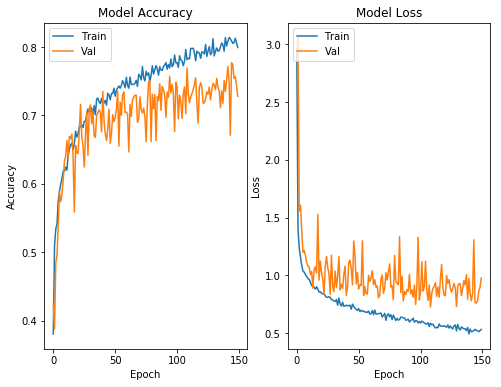

In [38]:
plot_metric_loss(history_resnet2, 'categorical_accuracy')

- In the end we achieve around 80% training accuracy and around 75% validation accuracy
- We could see that the model still suffers from high bias even with 150 epochs
- Next step could be either
    1. Build a better network architecture
    2. Do error analysis to see what kinds of image tends to be misclassified, and then do the necessary to solve them
    3. Tune better hyper-parameters which may be computational expensive